# The hyperdimensional transform: introduction

The hyperdimensional transform allows for converting functions into high-dimensional, holographic vectors, as known in the field of *hyperdimensional computing* or *vector symbolic architectures*.

This notebook supports our paper "*The Hyperdimensional Transform: a Holgraphic Representation of Functions*". It translates the theoretical concepts into simple, interpretable code. In a few lines, we show how one can implement the transform and reproduce the results in the paper. For example, the tutorial demonstrates how the transform allows one for easily solving a differential equation.

Note that this notebook is only supporting material and is not written a stand-alone tutorial. For theory, details, explanation and more examples, we refer the reader to our paper.

First, we include some supporting code. Then we define the domain: the interval $[0,1]$, represented by $m$ equidistant points

In [1]:
using LinearAlgebra, Plots, StatsBase

# supporting code
function phi(x, D, l; real=true)
    phi_x = zeros(m, D)
    for i in 1:D
        signs = rand((-1,1), ceil(Int, 1/l)+1)
        shift = l * rand()
        phi_x[:,i] .= @. (1-cos(2π/l*(x+shift))) * signs[(ceil(Int, (x+shift)/l))]
    end
    return real ? phi_x : sign.(phi_x)
end

# compute the normalization coefficients at the discrete points via
# iteratively solving the Hammerstein equation.
function find_normalization(K; n_iter=10)
    n = sqrt.(mean(K, dims=1))[:]
    onetilde = mean(K ./ n, dims=1)[:] ./ n
    p = plot(onetilde, label="iteration 0", legend=:bottomright)
    for i in 1:n_iter
        @. n = n * sqrt(onetilde)
        onetilde .= mean(K ./ n, dims=1)[:] ./ n
        plot!(onetilde, label="iteration $i")
    end
    return p, n
end

function delta(x, D, L; real)
    phi_x = phi(x, D, l; real)
    p,n = find_normalization(phi_x * phi_x' / D, n_iter=10)
    return phi_x ./ n
end

function deriv_encoding(X; h=1)
    res = zero(X)
    for i in 1:size(X,1)
        l = max(i-h, 1)
        u = min(i+h, size(X,1))
        res[i,:] = (X[u,:] - X[l,:]) / (u - l) * m
    end
    return res
end

function plot_encoding(phi_x)
    p = plot(layout=(2,1), size=(600,600))
    plot!(p[1], x, phi_x[:,1:4], label=["ϕ₁(x)" "ϕ₂(x)" "ϕ₃(x)" "..."], xlabel="x", ylabel="random function value")
    plot!(p[2], x, phi_x*phi_x[1,:] / D, label="ϕₓ*ϕ₀ / D", xlabel="x", ylabel="similarity to neighbors")
    plot!(p[2], x, phi_x*phi_x[125,:] / D, label="ϕₓ*ϕ₀₋₂₅ / D")
    plot!(p[2], x, phi_x*phi_x[250,:] / D, label="ϕₓ*ϕ₀₋₅ / D")
    plot!(p[2], x, phi_x*phi_x[375,:] / D, label="ϕₓ*ϕ₀₋₇₅ / D")
    plot!(p[2], x, phi_x*phi_x[500,:] / D, label="ϕₓ*ϕ₁ / D")
end

function plot_normalized_encoding(delta_x)
    p = plot(layout=(2,1), size=(600,600))
    plot!(p[1], x, delta_x[:,1:4], label=["δ₁(x)" "δ₂(x)" "δ₃(x)" "..."], xlabel="x", ylabel="random function value")
    plot!(p[2], x, delta_x*delta_x[1,:] / D, label="δₓ*δ₀ / D", xlabel="x", ylabel="similarity to neighbors")
    plot!(p[2], x, delta_x*delta_x[125,:] / D, label="δₓ*δ₀₋₂₅ / D")
    plot!(p[2], x, delta_x*delta_x[250,:] / D, label="δₓ*δ₀₋₅ / D")
    plot!(p[2], x, delta_x*delta_x[375,:] / D, label="δₓ*δ₀₋₇₅ / D")
    plot!(p[2], x, delta_x*delta_x[500,:] / D, label="δₓ*δ₁ / D")
end

m = 500
x = range(0, 1, length=m);

# Create an encoding

We create an encoding of the domain x: each point is mapped to a D-dimensoinal vector via a vector-valued function $\phi$. Each component can be seen as a random function switching randomly between 1 and -1. As a result, if points $x$ and $x'$ are close, then $\phi(x)$ and $\phi(x')$ are similar. If they are further away, then the random switching will lead to dissimilar representations. The rate at which this similarity drops is connected to the average frequency at wich the function switches, determined by lengthscale $l$. As with kernel methods, the lengthscale $l$ can be seen as a kind of bandwidth parameter.

First panel: we plot a few components of the encoding $\phi$ for each point $x$ in our interval.

Second panel: we plot the similarity between the components of $\phi(x)$ and $\phi(x')$ for a few fixed values of $x'$. The similarity is measured via the dot product, rescaled by the dimensionality $D$, i.e., the number of components.

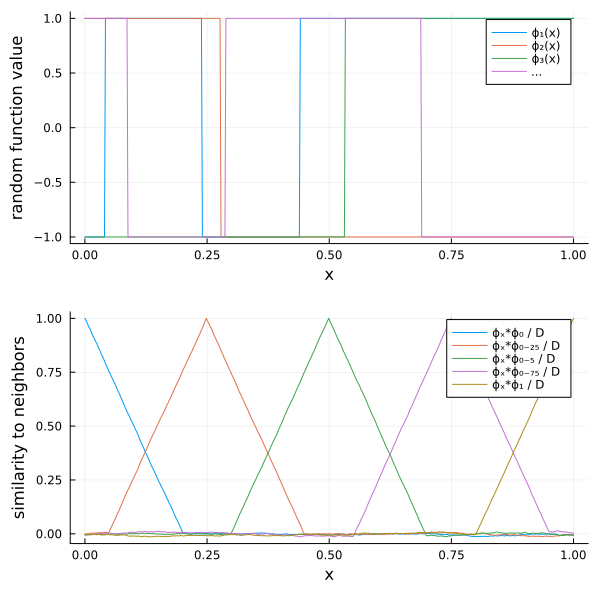

In [2]:
D, l =  20_000, 0.2;
phi_x = phi(x, D, l, real=false);
plot_encoding(phi_x)

If we select a shorter length scale $l=0.1$, the components $\phi$ switch more frequently and the similarity drops faster. When further away than the length scale, the vectors are maximally dissimilar (similarity of random vectors).

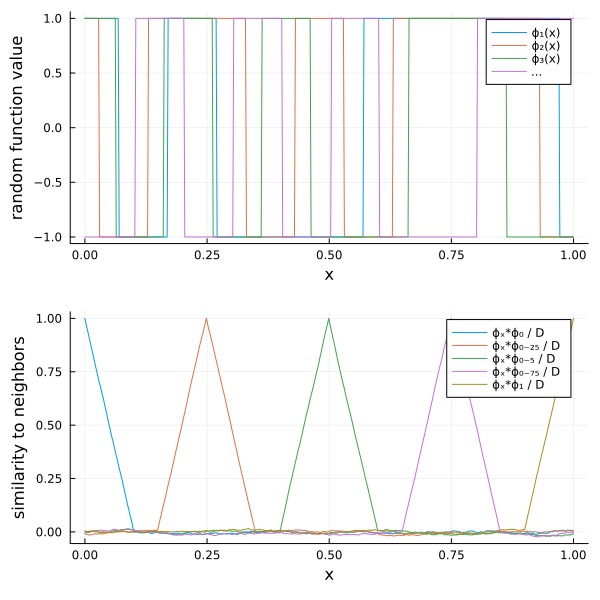

In [3]:
D, l =  20_000, 0.1;
phi_x = phi(x, D, l, real=false);
plot_encoding(phi_x)

Now follows a different way of encoding that was not presented in the paper; that has a similar motivation, but has new interesting properties.

Each component is now a real-valued function that is a concatenation of pieces of cosine functions that during one period are on the postive or on the negative side, randomly. Additionally, each component also has a random phase shift to induce translation invariance. One period is exactly the length scale. This encoding is more smooth, and even differentiable. As we will see, taking the sign of this encoding leads to the very same encoding as the bipolar one.

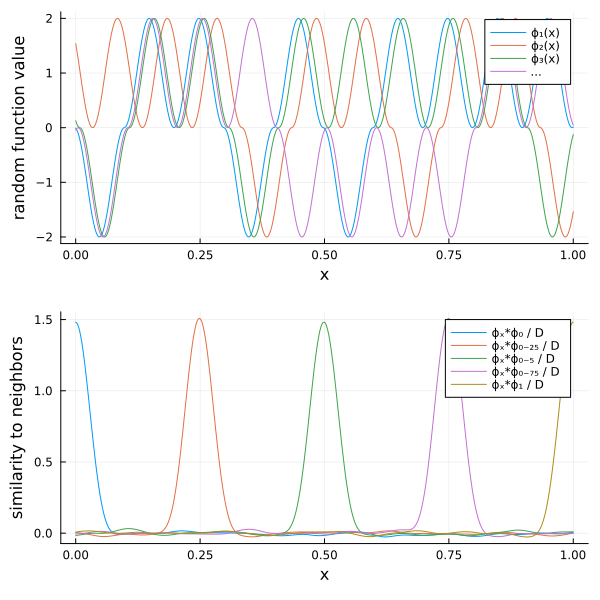

In [4]:
D, l =  20_000, 0.1;
phi_x = phi(x, D, l, real=true);
plot_encoding(phi_x)

Comparing to the bipolar encoding, the similarity to the closer neighbors is a bit higher, and drops faster for further-away points.

If we take the sign of this encoding, we arrive exactly at the bipolar encoding from earlier:

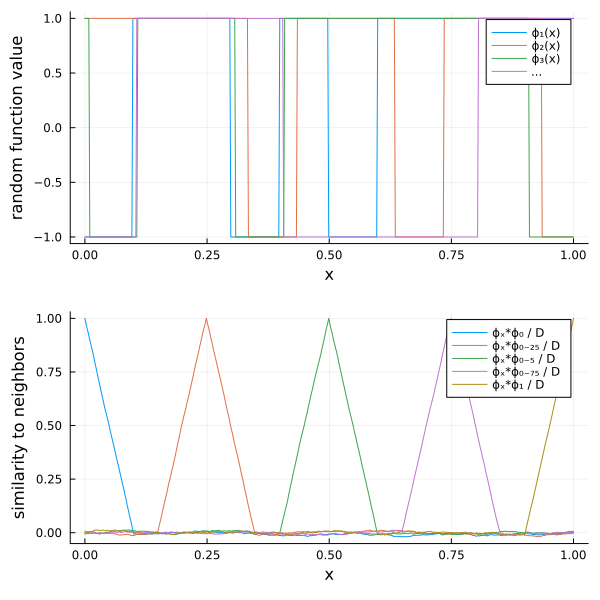

In [5]:
phi_x = sign.(phi_x);
plot_encoding(phi_x)

# Create a normalized encoding

In order to have we well-defined transformation, we need some kind of normalization. The integral transform will integrate on the domain [0,1]. However, as we see in the right hand-side panels above, integration would put less weight at the boundary vectors, compared to the ones in the middle, because the boundary vectors have less similar neighbors.

Therefore, we introduced the normalized version of the encoding, denoted by $\delta$. It may be seen as an approximation of a Dirac delta distribution with finite length scale $l$, represented via hyperdimensional vectors. The total mass under the curves in the right hand-side panel should be 1. The smaller the length scale $l$, the closer the Dirac distribution is approximated.

This normalized encoding $\delta$ is obtained by dividing the encoding $\phi$ by a function $n$ that can be found by solving a Hammerstein equation. One can observe that the amplitude of $\phi$ at the boundaries increases to compensate for the lower weight.

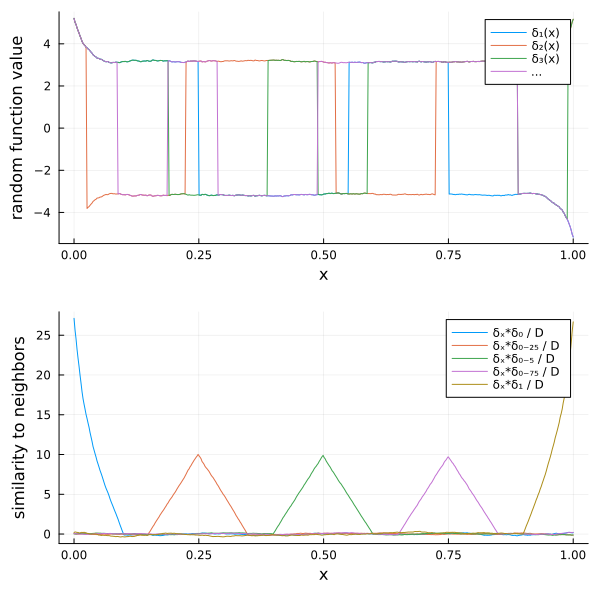

In [6]:
D, l =  20_000, 0.1;
delta_x = delta(x, D, l, real=false);
plot_normalized_encoding(delta_x)

# The transform

With the choice of our domain, the transform is now an integral $\int_0^1 f(x) \delta(x) \text{d}x$. We approximate this via our domain represented as $m$ points. The transform is then simply a matrix multiplication of the vector holding the function evaluations in all points $x$, and the matrix holding the D-dimensional representations of each x; dividend by the number of points $m$.

We plot the $D$ components of $F$, these seem indeed random, holographic.

In [7]:
# the function
f(x) = x * sin(20x)

# the encoding
D, l =  20_000, 0.1;
delta_x = delta(x, D, l, real=true);

# the transform
F = delta_x' * f.(x)  ./ m;

scatter(F, alpha=0.3)

Function evaluation of the inverse stransform, is a product with the delta representation. Note that the reproduced function is somewhat smoother due to the finite lengthscale. One might interpret the right hand-side panels above as the smoothing filters.

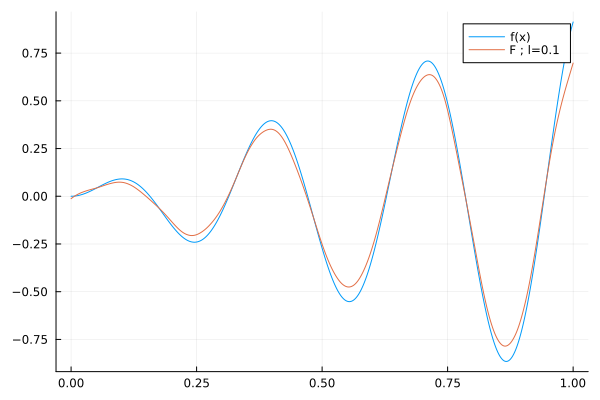

In [8]:
plot(x, f.(x), label="f(x)")
plot!(x, delta_x*F / D, label="F ; l=$l")

# Integrals

The Euclidean inner product $\frac{<F,F>}{D}$ approximates the function inner product $\int_0^1 f(x)f(x) \text{d}x$.

Due to the finite length scale and smoothing in the representation of F (see figure above), is the reproduced norm somewhat smaller.

In [9]:
n1 = F' * F / D
n2 = f.(x)' * f.(x) ./ m

n1, n2

(0.13946932126664752, 0.15830467214956118)

By setting one of the arguments of the inner product equal to the function 1, we can compute the integral of $f$.

In [10]:
o(x) = 1
O = delta_x' * o.(x) ./ m;

i1 = F' * O ./ D
i2 = f.(x)'* o.(x) ./ m

i1, i2

(-0.017169532082672558, -0.017169520211703655)

# Differentials

The derivatives of the transformed function can be computed via derivation of the the encoding, i.e.,

   $$\tilde{f} = <F, \delta>$$
   $$\tilde{f}' = <F, \delta'>$$
   $$\tilde{f}'' = <F, \delta''>$$
   $$\ldots$$

   Below, we plot the first derivatives of the transform of our function $f$.

the encoding

In [11]:
D, l =  20_000, 0.1;
delta_x = delta(x, D, l, real=true)

500×20000 Matrix{Float64}:
  2.92031      -0.539361    …   1.12872     -0.210577    10.281
  3.33809      -0.272529        0.716738    -0.0630698    9.63297
  3.74122      -0.101729        0.408776    -0.00282738   8.98598
  4.12549      -0.0155107       0.193706     0.0183951    8.34341
  4.48724       0.00380803      0.0617027    0.0997385    7.70777
  4.82397       0.0577263   …   0.00406753   0.238021     7.08233
  5.13323       0.169353        0.0130266    0.425402     6.46924
  5.41335       0.33161         0.0816061    0.654895     5.87106
  5.66234       0.538073        0.203489     0.920137     5.28949
  5.8784        0.782812        0.372862     1.21524      4.72635
  6.06073       1.06041     …   0.584364     1.53489      4.18417
  6.20865       1.36582         0.833004     1.87415      3.66521
  6.32044       1.69404         1.11389      2.228        3.17109
  ⋮                         ⋱                            
  0.118741      4.38834        -5.06832     -3.79728     -4

and the derivatives: a finite difference h=m*l (m:number of points in x, l: lenghtscale) is used.
A finite difference allows to filter some noise, as differentiating a noisy function may increase noise.

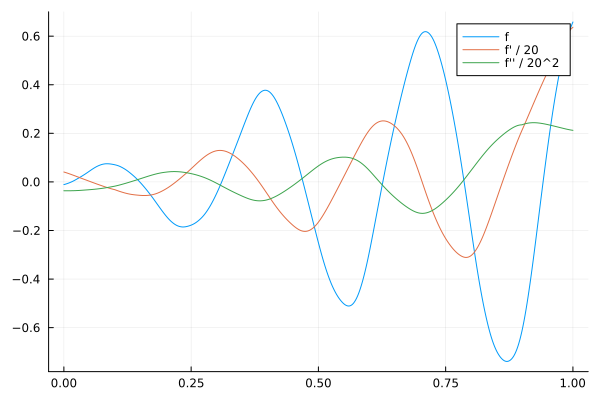

In [12]:
delta_x_ = deriv_encoding(delta_x, h = round(Int, m*l));
delta_x__ = deriv_encoding(delta_x_, h = round(Int, m*l));

F = delta_x' * f.(x)  / m;

plot(x, delta_x*F / D, label="f")
plot!(x, delta_x_*F / D / 20, label="f' / 20")
plot!(x, delta_x__*F / D / 20^2, label="f'' / 20^2")

# Solve differential equations

We show how these concepts can be used to solve a differential equation. We will use a constant $k$, and the solution of linear ridge regression. For the encoding, we will use only 5000 dimensions allowing for fast matrix inversion, and a shorter length scale $l=0.05$ for enough flexibility in the solution.

In [13]:
k = 10

# solution to ridge regression
function solve_ridge(X, B; λ=1)
    F =  (X'*X + λ*I) \ X'* B
    return F * D
end

# the encoding: fewer dimensions, shorter lengthscale
D, l =  5_000, 0.05;
delta_x = delta(x, D, l, real=true);

and the derivatives.

In [14]:
delta_x_ = deriv_encoding(delta_x, h = round(Int, m*l/5));
delta_x__ = deriv_encoding(delta_x_, h = round(Int, m*l/5));

## Exponential decay
The differential equation
$$
\frac{1}{k}f'(x) + f(x) = 0
$$
can, using the aforementioned expression of the derivative, be expressed for $F$
$$
<\frac{1}{k}\delta_x' + \delta_x, F> = 0 \,.
$$

When expressed for the $m$ points in our domain, the equation takes the form X*F = Y with X and Y computed as

In [15]:
X = 1 / k * delta_x_ + delta_x;
Y = zeros(m);

Boundary conditions can be added by concatenation. E.g. $f(0)=1$ is translated as an additional equation in $F$ via $<F, \delta_0> = 1$.

In [16]:
X = vcat(X, delta_x[1,:]')
Y = vcat(Y, 1);

Now we solve as a ridge regression, trying to fit the equations as well as possible. The solution is plotted below

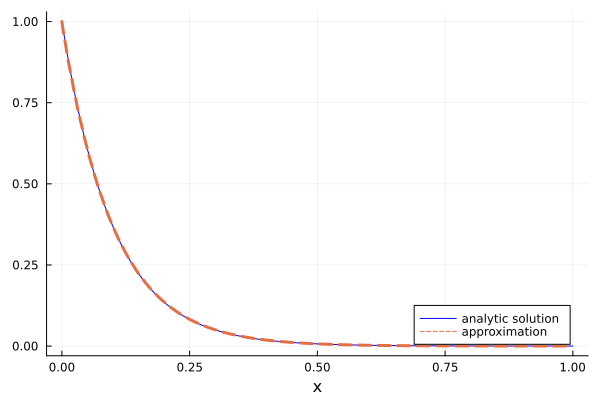

In [17]:
F = solve_ridge(X,Y, λ=1);
plot(x, c=:blue, exp.(-k*x), label="analytic solution", legend=:bottomright, xlabel="x")
plot!(x, delta_x*F / D, linestyle=:dash, linewidth=3, label="approximation")

## Harmonic oscillator
The differential equation
$$
\frac{1}{k^2} f'' + f= 0
$$
can, using the aforementioned expression of the derivative, be expressed for $F$
$$
<\frac{1}{k^2}\delta_x'' + \delta_x, F> = 0 \,.
$$

Now, we solve this equation anolog to above.

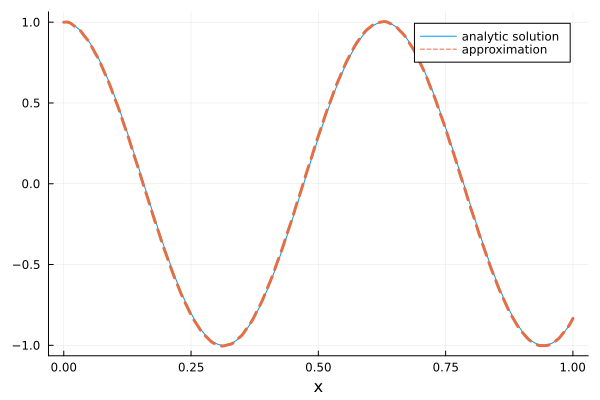

In [18]:
# equation
X = 1/k^2*delta_x__ + delta_x
Y = zeros(m)

# boundary condition: f(x)=1
X = vcat(X, delta_x[1,:]')
Y = vcat(Y, 1)

# solve
F = solve_ridge(X, Y, λ=1);

# plot
plot(x, cos.(k*x), label="analytic solution", xlabel="x")
plot!(x, delta_x*F / D, linestyle=:dash,linewidth=3, label="approximation")

#  Damped harmonic oscillator
The differential equation
$$
\frac{1}{k^2}f'' + \frac{1}{k}f' + f = 0
$$
can, using the aforementioned expression of the derivative, be expressed for $F$:
$$
<\frac{1}{k^2}\delta_x''+\frac{1}{k}\delta_x' + \delta_x, F> = 0 \,.
$$

Now, we solve this equation anolog to above.


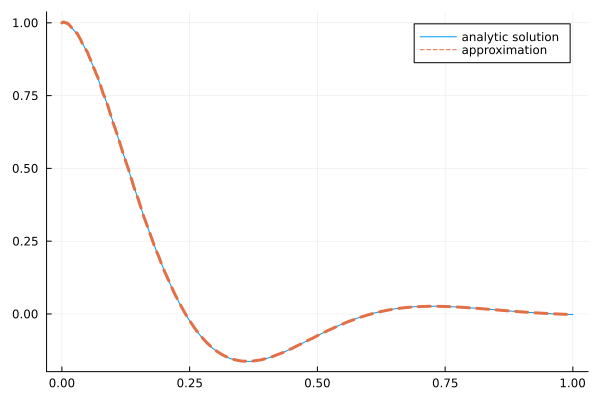

In [19]:
# equation
X = 1/k^2*delta_x__ + 1/k*delta_x_ + delta_x
Y = zeros(m)

# boundary conditions: f(0):1, f'(0)=0
X = vcat(X, delta_x[1,:]', delta_x_[1,:]')
Y = vcat(Y, 1, 0)

# solve
F = solve_ridge(X, Y, λ=1);
 
# plot
dampedosc(t) = 1/3 * exp(-5*t) *(sqrt(3)*sin(5sqrt(3)*t) + 3cos(5*sqrt(3)*t))
plot(x, dampedosc.(x), label="analytic solution")
plot!(x, delta_x*F / D, linestyle=:dash,linewidth=3, label="approximation")